# Import Library

Import some needs library for Project

In [2]:
import tensorflow as tf
import pandas as pd
import random
import numpy as np
import os
import matplotlib.pyplot as plt
import shutil
import seaborn as sns


from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report

from tensorflow.keras import models, layers
from tensorflow import keras
from tensorflow.keras.layers import Input, Lambda, Flatten, Reshape, Conv2D, MaxPooling2D, Dropout, Activation, BatchNormalization
from tensorflow.keras.layers import Dense, Concatenate, Add, Reshape, Dot, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.optimizers import RMSprop, SGD, Adam
from keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, array_to_img, img_to_array

from tensorflow.keras.applications import InceptionV3, ResNet152V2, VGG16, VGG19
from keras.applications.densenet import DenseNet201
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Preprocessing

## Setting Some Hyper-Parameters

In [3]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS   = 3

## Process Dataset with csv

In [4]:
#Loading the text file
df = pd.read_csv("/kaggle/input/breakhis/Folds.csv")

In [5]:
#find duplicate rows across specific columns
duplicateRows = df[df.duplicated(['mag', 'grp', 'filename'])]

In [6]:
duplicateRows

fold  mag    grp                                           filename
7909      2  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
7910      2  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
7911      2  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
7912      2  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
7913      2  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
...     ...  ...    ...                                                ...
39540     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39541     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39542     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39543     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...
39544     5  400   test  BreaKHis_v1/histology_slides/breast/malignant/...

[24822 rows x 4 columns]

Where find out, from index 7909, data will be duplicate with differences Fold

In [7]:
dataset = df.iloc[:7909, :]

In [8]:
dataset.shape[0]

7909

In [9]:
#Renaming the column filename to path
dataset = dataset.rename(columns = {"filename":"path"})
#Show first 5 entries
dataset.head()

fold  mag    grp                                               path
0     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
1     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
2     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
3     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...
4     1  100  train  BreaKHis_v1/histology_slides/breast/benign/SOB...

In [10]:
#Creating new columns for the filename, file location and labels from the path column
dataset['filename'] = dataset['path'].apply(lambda x:x.split("/")[-1])
dataset["label"] = dataset['path'].apply(lambda x: x.split("/")[3])
dataset["sublabel"] = dataset['path'].apply(lambda x: x.split("/")[5])
dataset['file_loc'] = dataset['label'] + "_" + dataset['filename']

**Encoding the class to integer**

Setting benign to 0
Setting Malignant to 1

In [11]:
#Encoding the class to integer
dataset['class'] = dataset['label'].apply(lambda x: 0 if x =='benign' else 1)

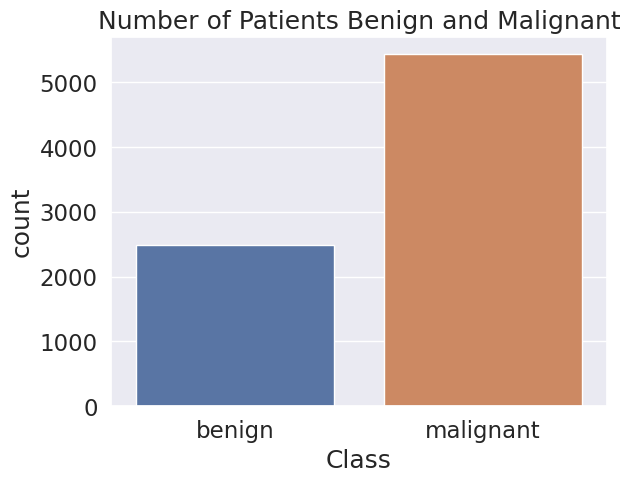

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'label' is a categorical column in your DataFrame
# If it's not, you might need to replace 'label' with the actual column name.
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

# Assuming 'dataset' is your DataFrame
sns.countplot(data=dataset, x="label")
plt.xlabel("Class")
plt.title("Number of Patients Benign and Malignant")
plt.savefig('Number of Patients Benign and Malignant.png', bbox_inches="tight")
plt.show()


In [13]:
print('Number of samples for each class: \n', dataset["class"].value_counts())

Number of samples for each class: 
 class
1    5429
0    2480
Name: count, dtype: int64


In [14]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7909 entries, 0 to 7908
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   fold      7909 non-null   int64 
 1   mag       7909 non-null   int64 
 2   grp       7909 non-null   object
 3   path      7909 non-null   object
 4   filename  7909 non-null   object
 5   label     7909 non-null   object
 6   sublabel  7909 non-null   object
 7   file_loc  7909 non-null   object
 8   class     7909 non-null   int64 
dtypes: int64(3), object(6)
memory usage: 556.2+ KB


In [15]:
dataset['mag'].unique()

array([100, 200,  40, 400])

In [16]:
dataset_mag = dict()
dataset_mag[40] = dataset.loc[dataset['filename'].str.contains('40')]
dataset_mag[100] = dataset.loc[dataset['filename'].str.contains('100')]
dataset_mag[200] = dataset.loc[dataset['filename'].str.contains('200')]
dataset_mag[400] = dataset.loc[dataset['filename'].str.contains('400')]

In [17]:
def count_dataset(datasets):
    i = 0
    fig, ax = plt.subplots(2, 2, figsize=(20, 16)) 
    for key, value in datasets.items():
        i += 1
        plt.subplot(2,2, i)
        sns.set(font_scale=1.5)
        sns.set_style("darkgrid")
        # Assuming 'dataset' is your DataFrame
        sns.countplot(data=value, x="label")
        plt.xlabel("Class")
        plt.title("Benign and Malignant with magnification X" + str(key))
    plt.savefig('all_data.png')
    plt.show()
    

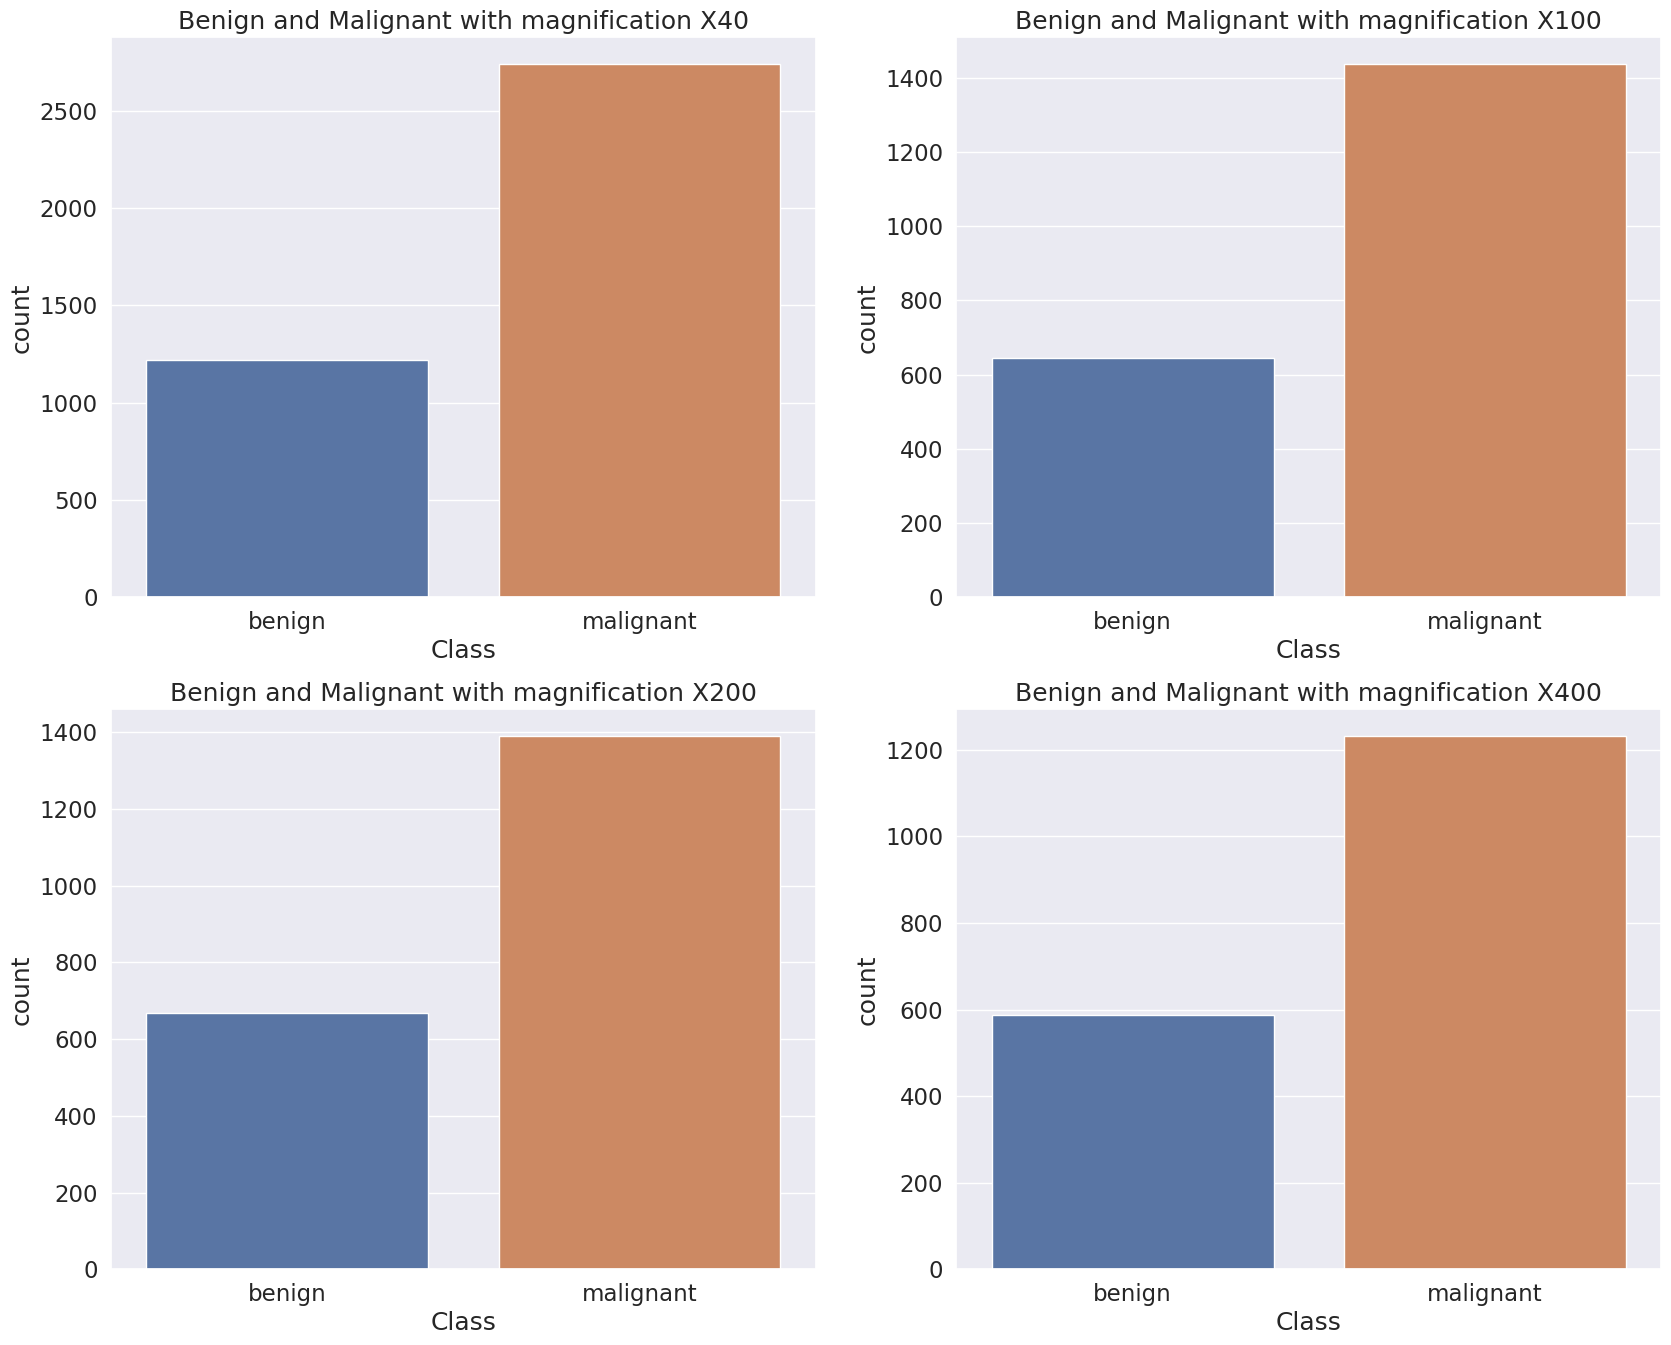

In [18]:
count_dataset(dataset_mag)

In [19]:
for key, value in dataset_mag.items():
    value_counts = value['label'].value_counts()
    print(f'The number patients of Benign and Malignant of Magnitude X{key}')
    print(value_counts)
    print(f'The ratio of balance data is: {round(value_counts.iloc[1] / value_counts.iloc[0], 2)}\n\n')

The number patients of Benign and Malignant of Magnitude X40
label
malignant    2741
benign       1217
Name: count, dtype: int64
The ratio of balance data is: 0.44


The number patients of Benign and Malignant of Magnitude X100
label
malignant    1437
benign        644
Name: count, dtype: int64
The ratio of balance data is: 0.45


The number patients of Benign and Malignant of Magnitude X200
label
malignant    1390
benign        667
Name: count, dtype: int64
The ratio of balance data is: 0.48


The number patients of Benign and Malignant of Magnitude X400
label
malignant    1232
benign        588
Name: count, dtype: int64
The ratio of balance data is: 0.48




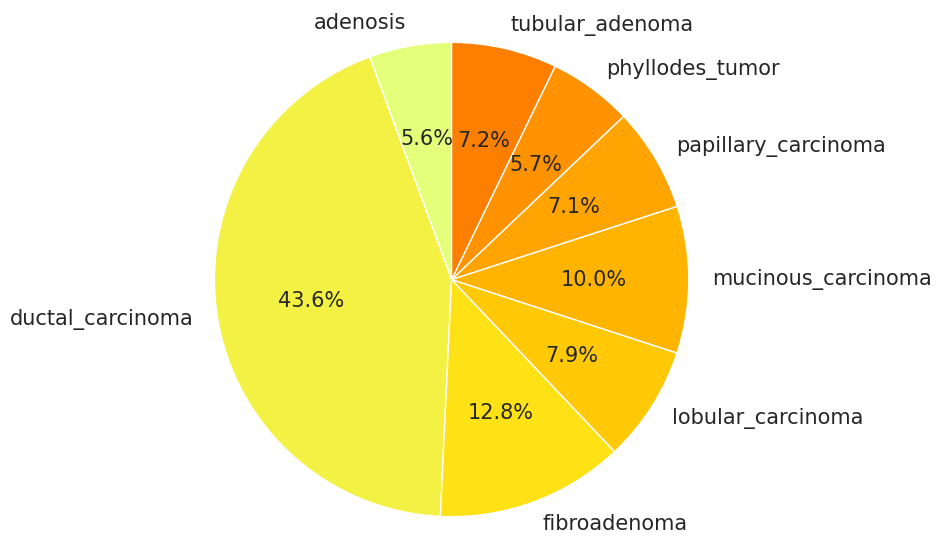

In [20]:
dataset.groupby(['sublabel']).size().plot(kind='pie', autopct="%.1f%%", figsize=(10,7), colormap='Wistia', startangle=90, textprops={'size': 'smaller'}, radius=1.1)
plt.savefig('Percentage_of_sublabels')

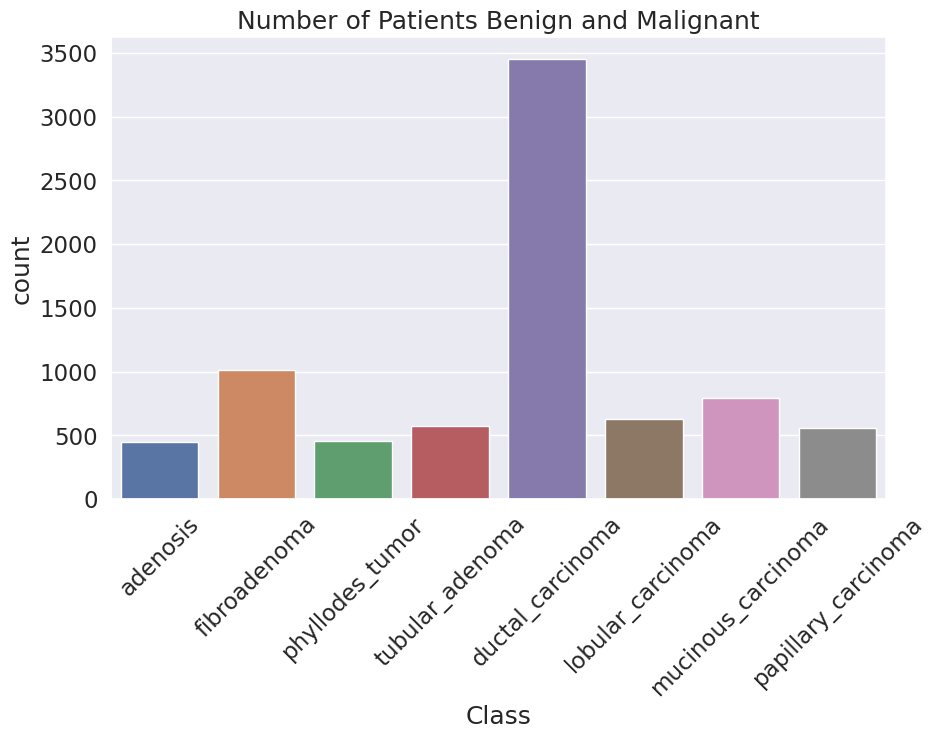

In [21]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

# Assuming 'dataset' is your DataFrame
sns.countplot(data=dataset, x="sublabel")
plt.xlabel("Class")
plt.title("Number of Patients Benign and Malignant")
plt.xticks(rotation=45)
plt.savefig('barchar.png')
plt.show()

# Augumentation

In [22]:
dataset['sublabel'].value_counts()

sublabel
ductal_carcinoma       3451
fibroadenoma           1014
mucinous_carcinoma      792
lobular_carcinoma       626
tubular_adenoma         569
papillary_carcinoma     560
phyllodes_tumor         453
adenosis                444
Name: count, dtype: int64

In [23]:
sublabels = dataset['sublabel'].unique()

In [24]:
dataset_without_M_DC = dataset.loc[dataset['sublabel'] != 'ductal_carcinoma']

In [25]:
dataset_M_DC = dataset.loc[dataset['sublabel'] == 'ductal_carcinoma']

In [26]:
dataset_M_DC.shape

(3451, 9)

There are 3451 samples about Ductal Carcinoma, meanwhile, other subclasses just around 400 - 1000 samples. So I will divided it into 4 parts and just keep 1/4 data of DC samples.

In [27]:
dataset_M_DC.shape[0]/4

862.75

We will keep 863 samples of DC for Data balance. But we have four the difference zoom, X40, X100, X200, X400. So, we must divide it so balance

In [28]:
dataset_M_DC.shape[0]/16

215.6875

In each magnitude Zoom, we will keep 216 samples at all, we have 864 samples for DC

In [29]:
filter_data = list()
x100 = 0
x200=0
x400=0
x40=0

for index, row in dataset_M_DC.iterrows():
    filename = row['filename']
    if (filename.split('-')[3]=='40') and (x40<217):
        x40+=1
        filter_data.append(row)
    elif (filename.split('-')[3]=='200') and (x200<217):
        x200+=1
        filter_data.append(row)
    elif (filename.split('-')[3]=='100') and (x100<217):
        x100+=1
        filter_data.append(row)

    elif (filename.split('-')[3]=='400') and (x400<217):
        x400+=1
        filter_data.append(row)


In [30]:
new_dataset_M_DC = pd.DataFrame(filter_data)
new_dataset_M_DC.shape

(868, 9)

In [31]:
new_dataset = pd.concat([dataset_without_M_DC, new_dataset_M_DC], ignore_index=True)

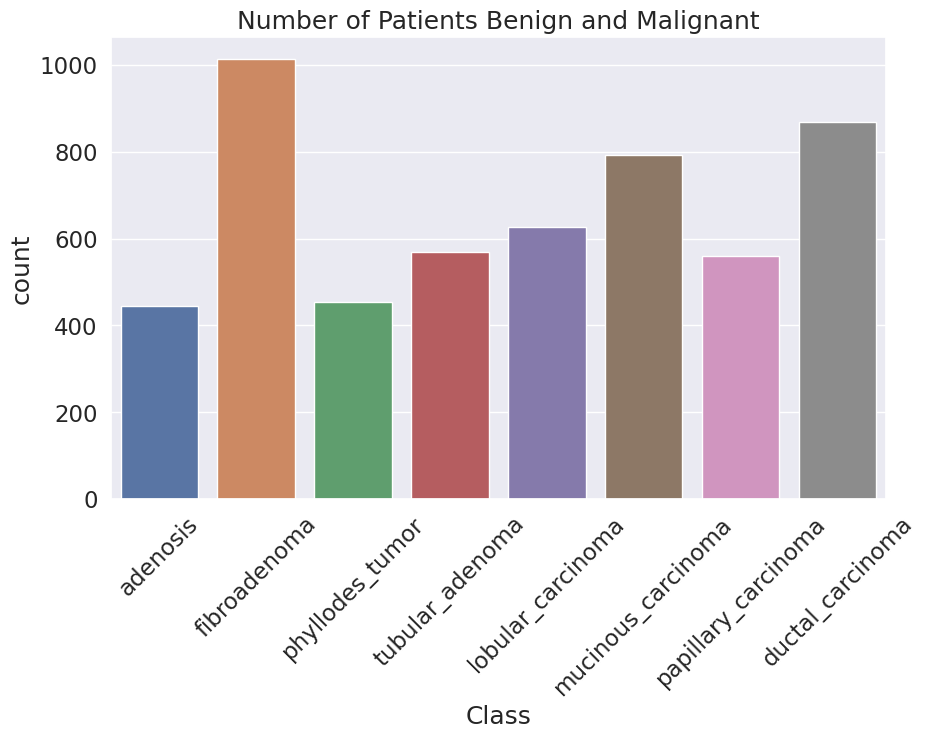

In [32]:
plt.figure(figsize=(10,6))
sns.set(font_scale=1.5)
sns.set_style("darkgrid")

# Assuming 'dataset' is your DataFrame
sns.countplot(data=new_dataset, x="sublabel")
plt.xlabel("Class")
plt.title("Number of Patients Benign and Malignant")
plt.xticks(rotation=45)
plt.savefig('Data After Augumetation.png',  bbox_inches="tight")
plt.show()

In [33]:
dataset = new_dataset

# Data Preprogressing

In [34]:
#Creating new directory
os.makedirs("/kaggle/working/Image_Dataset/")
#Creating new directory for benign
os.makedirs("/kaggle/working/Image_Dataset/Benign/")
#Creating new directory for malignant
os.makedirs("/kaggle/working/Image_Dataset/Malignant/")

In [35]:
#Moving all the images into one folder (Image_Dataset)
i = 0
for p in dataset['path']:
    src = "/kaggle/input/breakhis/BreaKHis_v1/" + p
    dest = "/kaggle/working/Image_Dataset/"
    if dataset["class"][i] == 0:
        dest = "/kaggle/working/Image_Dataset/Benign/"
    else:
        dest = "/kaggle/working/Image_Dataset/Malignant/"
    #saving the files with its corresponding class and patient_id
    dest = os.path.join(dest,src.split("/")[7]+ "_" + src.split("/")[-1])
#     if src.split('/')[-2] == '400X':
#         shutil.copyfile(src,dest)
#         i +=1
    shutil.copyfile(src,dest)
    i +=1

In [36]:
train_datagen = ImageDataGenerator(rescale = 1./255)

In [37]:
train_path = './Image_Dataset'
train_set = train_datagen.flow_from_directory(train_path,
                                              target_size = (IMAGE_SIZE,IMAGE_SIZE),
                                              batch_size = BATCH_SIZE,
                                              class_mode = 'categorical',
                                              shuffle=True)

Found 5326 images belonging to 2 classes.


In [38]:
from sklearn.model_selection import train_test_split

train_images, test_images, train_labels, test_labels = train_test_split(
    train_set.filenames,
    train_set.classes,
    test_size=0.2,
    random_state=42,
    stratify=train_set.classes
)

In [39]:
class My_Custom_Generator(keras.utils.Sequence):

  def __init__(self, image_filenames, labels, directory, batch_size):
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    self.directory = directory

  def __len__(self):
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)

  def __getitem__(self, idx):
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    data = np.array([
            image.img_to_array(image.load_img(os.path.join(self.directory, file_name), target_size=(256, 256)))
               for file_name in batch_x])/255.0

    return (data, np.array(batch_y))

  def generator(self):
    for idx in range(len(self)):
      yield self.__getitem__(idx)

  def get_dataset(self):
    output_signature = (
        tf.TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32),
        tf.TensorSpec(shape=(None,), dtype=tf.int32)
    )

    return tf.data.Dataset.from_generator(
        self.__getitem__,
        output_signature=output_signature
    )

In [40]:
# my_train_batch_generator = My_Custom_Generator(train_images, train_labels, train_path, 32)
my_test_batch_generator = My_Custom_Generator(test_images, test_labels, train_path, 32)

In [41]:
input_shape = (IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
inputs_shape = Input(shape=input_shape)

In [42]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4, restore_best_weights=True)

In [43]:
def eval_prioritization_strategy(prioritizer, x_train, y_train, epoch=12):
    train_indices = range(len(x_train))
    NUM_SAMPLE = round(len(x_train) * 0.05)
    print(NUM_SAMPLE)
    START_SAMPLE = round(len(x_train) * 0.1)
    test_accuracies = []
    x_train_subset = np.zeros([0,])
    y_train_subset = np.empty([0,])
    inception_model = ResNet152V2(
        weights="imagenet",
        input_tensor=inputs_shape,
        input_shape=(256, 256, 3),
        include_top=False
    )
    for layer in inception_model.layers[:140]:
        layer.trainable = False
    for i in range(epoch):
        if i == 0:
            selected_indices = train_indices[0:START_SAMPLE]
            train_indices = train_indices[START_SAMPLE:]
        else:
            selected_indices = train_indices[0:NUM_SAMPLE]
            train_indices = train_indices[NUM_SAMPLE:]
        x_train_subset = np.concatenate((x_train_subset, x_train[selected_indices,...]))
        y_train_subset = np.concatenate((y_train_subset, y_train[selected_indices,...]))
        my_train_batch_generator = My_Custom_Generator(x_train_subset, y_train_subset, train_path, 32)
        my_predict_batch_generator = My_Custom_Generator(x_train[train_indices,...], y_train[train_indices,...], train_path, 32)
        x3 = inception_model.output
        x3 = tf.keras.layers.GlobalAveragePooling2D()(x3)
        x3 = Dense(512, activation = "relu")(x3)
        x3 = tf.keras.layers.Dropout(0.2)(x3)
        x3 = tf.keras.layers.Dense(256, activation='relu')(x3)   # pass the merged tensor to the Dense layer, not the Concatenate layer output
        d1 = tf.keras.layers.Dropout(0.2)(x3)
        h2 = tf.keras.layers.Dense(128, activation = "relu")(x3)
        d2 = tf.keras.layers.Dropout(0.2)(h2)

        output = tf.keras.layers.Dense(1, activation='sigmoid')(d2)

        model = tf.keras.Model(inputs=inputs_shape, outputs=output)

        model.compile(optimizer='adam',
                      loss='binary_crossentropy',
                      metrics=['accuracy'])

        model.fit(my_train_batch_generator, epochs=20, verbose=0, callbacks=[early_stopping])
        loss, accuracy = model.evaluate(my_test_batch_generator, verbose=1)
        test_accuracies.append(accuracy)
        print('Training data size of %d => accuracy %f' % (x_train_subset.shape[0], accuracy))

        predictions = model.predict(my_predict_batch_generator)
        train_indices = prioritizer(train_indices, predictions)

    return test_accuracies


In [44]:
def ratio_prioritizer(indices, predictions):
    predictions = np.array([[abs(item[0] - 0.5) + 0.5, 1 - (abs(item[0] - 0.5) + 0.5)] if item[0] <= 0.5 else [1 - (abs(item[0] - 0.5) + 0.5), abs(item[0] - 0.5) + 0.5] for item in predictions])
    p = -np.sort(-predictions) # sort in descending order
    p = p[:,1] / p[:,0] 
    p = list(zip(indices, p))
    p.sort(key=lambda x : x[1]) # sort in ascending order
    return list(zip(*p))[0]

In [45]:
train_images = np.array(train_images)
train_labels = np.array(train_labels)

In [46]:
accuracy = eval_prioritization_strategy(ratio_prioritizer, train_images, train_labels)

213
234545216/234545216 ━━━━━━━━━━━━━━━━━━━━ 10s 0us/step


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1710897927.494393      92 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1710897927.674203      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710897991.743820      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.

 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.6094 - loss: 8.8272 

W0000 00:00:1710898152.626106      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 493ms/step - accuracy: 0.5734 - loss: 7.1053


W0000 00:00:1710898168.948066      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 426 => accuracy 0.569418
  2/120 ━━━━━━━━━━━━━━━━━━━━ 8s 73ms/step  

W0000 00:00:1710898179.118825      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


120/120 ━━━━━━━━━━━━━━━━━━━━ 68s 491ms/step


W0000 00:00:1710898365.576424      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 129ms/step - accuracy: 0.8906 - loss: 0.9389

W0000 00:00:1710898652.590239      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 487ms/step - accuracy: 0.8726 - loss: 1.2063


W0000 00:00:1710898668.695551      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 639 => accuracy 0.878049
  2/114 ━━━━━━━━━━━━━━━━━━━━ 8s 74ms/step  

W0000 00:00:1710898679.355130      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


114/114 ━━━━━━━━━━━━━━━━━━━━ 64s 472ms/step


W0000 00:00:1710898861.593588      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 135ms/step - accuracy: 0.8828 - loss: 1.5501

W0000 00:00:1710899185.072750      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 483ms/step - accuracy: 0.8515 - loss: 2.1703


W0000 00:00:1710899201.068721      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 852 => accuracy 0.854597
  2/107 ━━━━━━━━━━━━━━━━━━━━ 6s 66ms/step  

W0000 00:00:1710899211.038694      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


107/107 ━━━━━━━━━━━━━━━━━━━━ 62s 491ms/step


W0000 00:00:1710899392.196465      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 126ms/step - accuracy: 0.8125 - loss: 1.1831

W0000 00:00:1710899766.821922      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 27s 491ms/step - accuracy: 0.8442 - loss: 1.4026


W0000 00:00:1710899783.058614      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 1065 => accuracy 0.862101
  2/100 ━━━━━━━━━━━━━━━━━━━━ 6s 68ms/step  

W0000 00:00:1710899793.031282      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


100/100 ━━━━━━━━━━━━━━━━━━━━ 60s 511ms/step


W0000 00:00:1710899975.373960      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.8828 - loss: 0.8624

W0000 00:00:1710900427.538011      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 500ms/step - accuracy: 0.8742 - loss: 1.2016


W0000 00:00:1710900444.092415      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 1278 => accuracy 0.879925
 2/94 ━━━━━━━━━━━━━━━━━━━━ 7s 77ms/step  

W0000 00:00:1710900473.422384      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


94/94 ━━━━━━━━━━━━━━━━━━━━ 57s 505ms/step


W0000 00:00:1710900655.053639      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1710900725.192683      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.8281 - loss: 2.3034

W0000 00:00:1710901142.710357      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 494ms/step - accuracy: 0.8494 - loss: 2.1021


W0000 00:00:1710901159.069933      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 1491 => accuracy 0.865854
 2/87 ━━━━━━━━━━━━━━━━━━━━ 5s 66ms/step  

W0000 00:00:1710901169.066781      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


87/87 ━━━━━━━━━━━━━━━━━━━━ 56s 534ms/step


W0000 00:00:1710901349.528512      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 127ms/step - accuracy: 0.8516 - loss: 2.2213

W0000 00:00:1710901885.140082      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 28s 514ms/step - accuracy: 0.8603 - loss: 1.9676


W0000 00:00:1710901902.158018      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 1704 => accuracy 0.869606
 2/80 ━━━━━━━━━━━━━━━━━━━━ 5s 70ms/step  

W0000 00:00:1710901912.287833      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


80/80 ━━━━━━━━━━━━━━━━━━━━ 56s 580ms/step


W0000 00:00:1710902093.057083      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 131ms/step - accuracy: 0.8594 - loss: 2.7746

W0000 00:00:1710902705.120741      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 498ms/step - accuracy: 0.8801 - loss: 2.0101


W0000 00:00:1710902721.602350      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 1917 => accuracy 0.887430
 2/74 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step  

W0000 00:00:1710902731.789022      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


74/74 ━━━━━━━━━━━━━━━━━━━━ 49s 537ms/step


W0000 00:00:1710902904.423561      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 128ms/step - accuracy: 0.9141 - loss: 1.0849

W0000 00:00:1710903543.707521      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 481ms/step - accuracy: 0.8833 - loss: 1.4551


W0000 00:00:1710903559.616460      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 2130 => accuracy 0.875235
 2/67 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step  

W0000 00:00:1710903569.541377      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


67/67 ━━━━━━━━━━━━━━━━━━━━ 43s 506ms/step


W0000 00:00:1710903736.474761      92 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 130ms/step - accuracy: 0.9219 - loss: 0.7763

W0000 00:00:1710904414.069199      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 485ms/step - accuracy: 0.8760 - loss: 1.3990


W0000 00:00:1710904430.144140      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 2343 => accuracy 0.876173
 2/60 ━━━━━━━━━━━━━━━━━━━━ 3s 64ms/step  

W0000 00:00:1710904441.061921      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


60/60 ━━━━━━━━━━━━━━━━━━━━ 41s 514ms/step


W0000 00:00:1710904605.094921      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 136ms/step - accuracy: 0.9062 - loss: 1.1282

W0000 00:00:1710905372.026332      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 26s 493ms/step - accuracy: 0.9011 - loss: 1.0283


W0000 00:00:1710905388.343759      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 2556 => accuracy 0.900563
 2/54 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step

W0000 00:00:1710905398.178487      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


54/54 ━━━━━━━━━━━━━━━━━━━━ 46s 687ms/step


W0000 00:00:1710905567.912150      94 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


 2/34 ━━━━━━━━━━━━━━━━━━━━ 4s 144ms/step - accuracy: 0.8828 - loss: 0.9909

W0000 00:00:1710906624.845845      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


34/34 ━━━━━━━━━━━━━━━━━━━━ 32s 653ms/step - accuracy: 0.8894 - loss: 1.2335


W0000 00:00:1710906646.450815      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


Training data size of 2769 => accuracy 0.902439
 2/47 ━━━━━━━━━━━━━━━━━━━━ 2s 62ms/step 

W0000 00:00:1710906657.970221      95 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


47/47 ━━━━━━━━━━━━━━━━━━━━ 45s 733ms/step


W0000 00:00:1710906691.700648      93 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


In [47]:
accuracies = dict()
accuracies['Ratio'] = accuracy

In [48]:
file_path = 'data.csv'
if os.path.exists(file_path):
    df_result = pd.read_csv(file_path)
    df_result['Ratio'] = prioritized_accuracies
    df_result.to_csv(file_path, mode='w', index=False)
else:
    df_result = pd.DataFrame.from_dict(accuracies)
    df_result.to_csv(file_path, mode='x',  index=False)